In [20]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
import copy
import random
import os

# lenstronomy imports
from lenstronomy.Util import util # translates information from arrays into pictures?
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.SimulationAPI.sim_api import SimAPI # Simulation API
from lenstronomy.LensModel.lens_model import LensModel # imports lens model
from lenstronomy.LightModel.light_model import LightModel # imports light model
from lenstronomy.Plots.lens_plot import lens_model_plot, arrival_time_surface # lens_model_plot: plots a lens model (convergence), caustics, and critical curves
import lenstronomy.Plots.plot_util as plot_util

In [38]:
# set up DES camera settings for simulation

DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 91 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.) # set cosmo

In [39]:
# set simulation function
def simulation (ra_source, dec_source, theta_E, lens_model):
    kwargs_ps = [{'ra_source': ra_source, 'dec_source': dec_source}] 
    
    if lens_model == 'SIE':
        ## define light model: 
        light_model=['SERSIC_ELLIPSE']
        lens_light_model_class = LightModel(light_model_list = light_model)
    
        kwargs_lens_light_mag_g = [{'magnitude': 17, 'R_sersic': 0.1, 'n_sersic': 2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]
        kwargs_source_mag_g = [{'magnitude': 20, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0.2, 'e2': -0.3, 'center_x': ra_source, 'center_y': dec_source}]
        kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': ra_source, 'dec_source': dec_source}]
    
        ## define lens model: 
        kwargs_lens = [{'theta_E': theta_E, 'e1': 0.1, 'e2': -0.2, 'center_x': 0, 'center_y': 0}, #SIE
              {'gamma1': 0.03, 'gamma2': 0.01}] # Shear
        lens_model_list = ['SIE', 'SHEAR']
    
    
    elif lens_model == 'SIS':
        ## define light model: 
        light_model=['SERSIC']
        lens_light_model_class = LightModel(light_model_list = light_model)
    
        kwargs_lens_light_mag_g = [{'magnitude': 17, 'R_sersic': 0.1, 'n_sersic': 2, 'center_x': 0, 'center_y': 0}]
        kwargs_source_mag_g = [{'magnitude': 20, 'R_sersic': 0.1, 'n_sersic': 1, 'center_x': ra_source, 'center_y': dec_source}]
        kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': ra_source, 'dec_source': dec_source}]
    
        ## define lens model: 
        kwargs_lens = [{'theta_E': theta_E, 'center_x': 0, 'center_y': 0}, #SIS
              {'gamma1': 0.03, 'gamma2': 0.01}] # Shear
        lens_model_list = ['SIS', 'SHEAR']
    
    elif lens_model == 'SPEP':
        ## define light model: 
        light_model=['SERSIC_ELLIPSE']
        lens_light_model_class = LightModel(light_model_list = light_model)
    
        kwargs_lens_light_mag_g = [{'magnitude': 16, 'R_sersic': 0.1, 'n_sersic': 2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]
        kwargs_source_mag_g = [{'magnitude': 19, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0.1, 'e2': -0.1, 'center_x': ra_source, 'center_y': dec_source}]
        kwargs_ps_mag_g = [{'magnitude': 20, 'ra_source': ra_source, 'dec_source': dec_source}]
    
        ## define lens model: 
        kwargs_lens = [{'theta_E': theta_E, 'gamma': 0.1, 'e1': 0.1, 'e2': -0.2, 'center_x': 0, 'center_y': 0}, #SPEP
              {'gamma1': 0.06, 'gamma2': 0.01}] # Shear
        lens_model_list = ['SPEP', 'SHEAR']
    
    elif lens_model == 'EPL':
        ## define light model: 
        light_model=['SERSIC_ELLIPSE']
        lens_light_model_class = LightModel(light_model_list = light_model)
    
        kwargs_lens_light_mag_g = [{'magnitude': 17, 'R_sersic': 0.1, 'n_sersic': 2, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}]
        kwargs_source_mag_g = [{'magnitude': 20, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0.2, 'e2': -0.3, 'center_x': ra_source, 'center_y': dec_source}]
        kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': ra_source, 'dec_source': dec_source}]
    
        ## define lens model: 
        kwargs_lens = [{'theta_E': theta_E, 'gamma': 0.01, 'e1': 0.1, 'e2': -0.2, 'center_x': 0, 'center_y': 0}, #EPL
              {'gamma1': 0.03, 'gamma2': 0.01}] # Shear
        lens_model_list = ['EPL', 'SHEAR']
    
    else:
        print("WRONG")
    
    
    ## Combine models: 
    kwargs_model = {'lens_model_list': lens_model_list,  # lens model                 
                'lens_light_model_list': light_model,  # unlensed light model
                'source_light_model_list': light_model,  # extended source light model
                'point_source_model_list': ['SOURCE_POSITION']}  # point source model

   
    # Configurations for simulated image for g,r,i
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model)

    # returns ImageModel class with my configurations
    imSim_g = sim_g.image_model_class(kwargs_numerics) 
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    # Define parameters for each band of colors:
    # g-band is defined above

    # r-band
    g_r_source = 1  # color mag_g - mag_r for source
    g_r_lens = -1  # color mag_g - mag_r for lens light
    g_r_ps = 0
    kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'] -= g_r_source

    kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps

    # i-band
    g_i_source = 2
    g_i_lens = -2
    g_i_ps = 0
    kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
    kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'] -= g_i_source

    kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
    kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps

    # translate magnitude kwargs into amplitude kwargs
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # add noise
    #image_g += sim_g.noise_for_model(model=image_g)
    #image_r += sim_r.noise_for_model(model=image_r)
    #image_i += sim_i.noise_for_model(model=image_i)

    # Plot Image

    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
    img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=10000)
    img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)
    img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=10000)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)


             




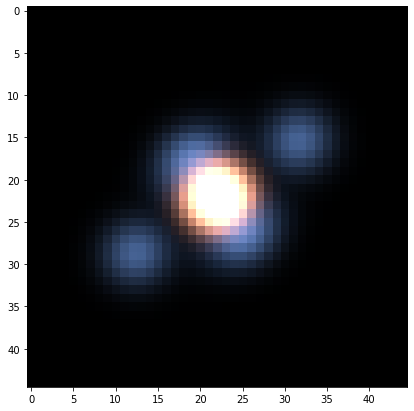

In [25]:
simulation(ra_source = 0, dec_source = 0, theta_E = 2, lens_model = 'EPL')

In [29]:
# create images 
#SIS and SIE first since we will only change ra_source (not dec_source) for those

# set bounds for ra_source
ra_source_list = np.linspace(-0.75,0.75,50) # must be less than 100 or have to append the naming system

# system for naming that will keep files in proper order
numbers = np.arange(0,len(ra_source_list), 1) 
naming = []

for x in numbers:
    y = str(x)
    if len(y)==1:
        z = '0'+ y
    else:
        z = y
    naming.append(z)

# create and name images
for (a,b) in zip(ra_source_list, naming):
    simulation(ra_source = a, dec_source = 0, theta_E = 3, lens_model = 'SIE')
    plt.savefig(str(b)+'.png', format = 'png')
    plt.close()


In [30]:
# make GIF

make_gif = 'convert -delay 10 -loop 0 *.png ra_source_SIE.gif'
os.system(make_gif)

0

In [31]:
# delete images when finished (clear space)
delete_images = 'rm *.png'
os.system(delete_images)

0

In [40]:
# create images 
# EPL and SPEP here 
# ra_source and dec_source will vary together

num_images = 50

# set bounds for ra_source and dec_source
ra_source_list = np.linspace(-4,4,num_images) # must be less than 100 else have to append the naming system
dec_source_list = np.linspace(-4,4,num_images)

# system for naming that will keep files in proper order
numbers = np.arange(0, len(ra_source_list), 1) 

naming = []

for x in numbers:
    y = str(x)
    if len(y)==1:
        z = '0'+ y
    else:
        z = y
    naming.append(z)

# create and name images
for (a,b,c) in zip(ra_source_list, dec_source_list, naming):
    simulation(ra_source = a, dec_source = b, theta_E = 2.5, lens_model = 'SPEP')
    plt.savefig(str(c)+'.png', format = 'png')
    plt.close()

In [41]:
# make GIF

make_gif = 'convert -delay 10 -loop 0 *.png ra_source_SPEP.gif'
os.system(make_gif)

0

In [42]:
# delete images when finished (clear space)
delete_images = 'rm *.png'
os.system(delete_images)

0